In [2]:
%load_ext autoreload
%autoreload 2

In [14]:
import zarr
import numpy as np
import matplotlib.pyplot as plt

from src.common.files import get_processed_path

import pytorch3d.transforms as pt
from src.common.geometry import matrix_to_axis_angle

import torch

In [4]:
path = get_processed_path(
    domain="sim",
    controller="diffik",
    demo_outcome="success",
    demo_source="teleop",
    randomness="low",
)

print(path)

z = zarr.open(path)

print(z.tree())

/data/scratch/ankile/furniture-data/processed/diffik/sim/one_leg/teleop/low/success.zarr
/
 ├── action
 │   ├── delta (26116, 10) float32
 │   └── pos (26116, 10) float32
 ├── augment_states (26116,) float32
 ├── color_image1 (26116, 240, 320, 3) uint8
 ├── color_image2 (26116, 240, 320, 3) uint8
 ├── critical_state_id (40,) int32
 ├── episode_ends (40,) uint32
 ├── failure_idx (40,) int32
 ├── furniture (40,) object
 ├── parts_poses (26116, 35) float32
 ├── pickle_file (40,) object
 ├── reward (26116,) float32
 ├── robot_state (26116, 16) float32
 ├── skill (26116,) float32
 └── success (40,) uint8


In [5]:
# Get the robot state data and look at the changes in the robot state
# Get the first 9 values: x, y, z + 6D orientation
robot_state_pose = z["robot_state"][:, :9]
robot_state_gripper = z["robot_state"][:, -1:]

# Concatenate the two arrays
robot_state = np.concatenate((robot_state_pose, robot_state_gripper), axis=-1)

robot_state.shape

(26116, 10)

(26076,)

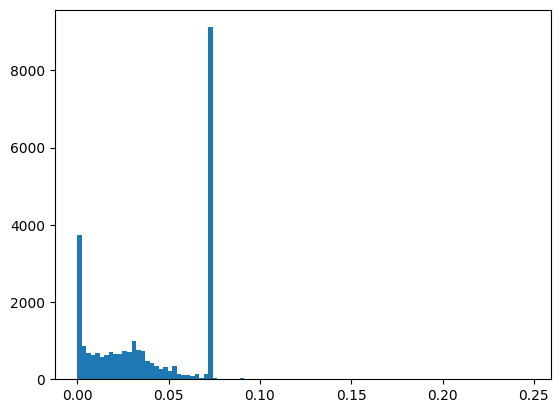

In [41]:
# Calculate the change in the EE's orientiation within each episode
ep_ends = z["episode_ends"][:-1]

ee_ori = robot_state[:, 3:9] # 6D orientation
ee_oris = np.split(ee_ori, ep_ends)

ee_ori_changes_deg = []

for ori in ee_oris:
    ori_mat = pt.rotation_6d_to_matrix(torch.tensor(ori))

    ori_mat_curr, ori_mat_next = ori_mat[:-1], ori_mat[1:]

    change_rad = pt.so3_relative_angle(ori_mat_curr, ori_mat_next).numpy()

    change_deg = np.rad2deg(change_rad)

    ee_ori_changes_deg.append(change_rad)

ee_ori_changes_deg = np.concatenate(ee_ori_changes_deg)

plt.hist(ee_ori_changes_deg, bins=100)

ee_ori_changes_deg.shape

In [63]:
# Get the changes in the robot state before we take the difference, we split it into episodes
ep_ends = z["episode_ends"][:-1]
ee_pos = robot_state[:, :3]
gripper = robot_state[:, -1:]

ee_poss = np.split(ee_pos, ep_ends)
grippers = np.split(gripper, ep_ends)

ee_pos_changes = np.concatenate([np.diff(ep, axis=0) for ep in ee_poss], axis=0)
ee_pos_distances = np.linalg.norm(ee_pos_changes, axis=-1)

gripper_changes = np.concatenate([np.diff(ep, axis=0) for ep in grippers], axis=0)

# Concatenate the changes
robot_state_changes = np.concatenate((ee_pos_distances[:, None], ee_ori_changes_deg[:, None], gripper_changes), axis=-1)


robot_state_changes.shape

(26076, 3)

In [58]:
# Normalize the change in the robot state by the mean of the absolute value of the changes
robot_state_changes = robot_state_changes / np.mean(np.abs(robot_state_changes), axis=0)

In [64]:
# Get the magnitude of the changes
robot_state_diff_mag = np.linalg.norm(robot_state_changes, axis=-1)

robot_state_diff_mag.shape, robot_state_diff_mag.min(), robot_state_diff_mag.max()

((26076,), 1.08966115e-05, 0.24836539)

In [65]:
robot_state_diff_mag

array([0.01348681, 0.02361583, 0.02814065, ..., 0.02114263, 0.02298119,
       0.02839531], dtype=float32)

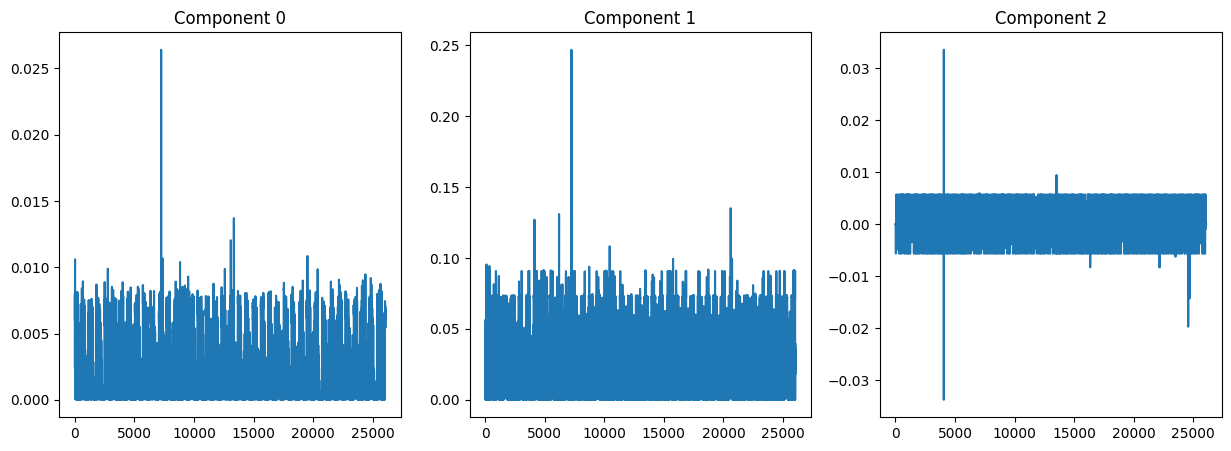

In [66]:
# Plot the magnitude of the changes for each of the 3 components
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axs):
    ax.plot(robot_state_changes[:, i])
    ax.set_title(f"Component {i}")

plt.show()

(0.0, 0.01)

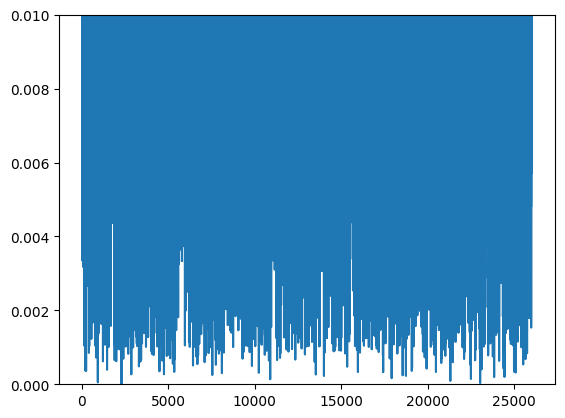

In [70]:
# Plot the magnitude in one plot
plt.plot(robot_state_diff_mag)

# Set the y-axis limits to very close to 0
plt.ylim(0, 0.01)

In [71]:
np.isclose(robot_state_changes, 0, rtol=1)

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [False, False,  True],
       [False, False,  True],
       [False, False,  True]])

In [79]:
# Find rows where all the changes are close to zero
close_to_zero = np.all(np.isclose(0, robot_state_changes, atol=0.001), axis=-1)

close_to_zero.sum()

289

In [20]:
euler = pt.matrix_to_euler_angles(pt.rotation_6d_to_matrix(torch.tensor([-0.19, -0.04, -0.15, -0.01,  0.  ,  0.04])), "XYZ")

euler, np.degrees(euler.numpy())

(tensor([-1.6255, -0.6578,  2.9341]),
 array([-93.13305 , -37.687492, 168.11133 ], dtype=float32))

In [22]:
rotvec = matrix_to_axis_angle(pt.rotation_6d_to_matrix(torch.tensor([-0.19, -0.04, -0.15, -0.01,  0.  ,  0.04])))

np.degrees(np.linalg.norm(rotvec.numpy())), np.degrees(rotvec.numpy())

(160.90091, array([  47.64943 , -107.778275, -109.55583 ], dtype=float32))

In [81]:
# Look at the normalized changes of actions
actions = z["action/pos"][:]

actions.shape

(26116, 10)

In [82]:
from src.dataset.normalizer import LinearNormalizer

In [83]:
normalizer = LinearNormalizer()
actions = torch.tensor(actions, dtype=torch.float32)

normalizer.fit({"actions": actions})

actions_normalized = normalizer(actions, "actions", forward=True).numpy()

actions_normalized.shape


(26116, 10)

In [84]:
# Split and find the diffs
ep_ends = z["episode_ends"][:-1]

actions = np.split(actions_normalized, ep_ends)

actions_diffs = np.concatenate([np.diff(ep, axis=0) for ep in actions], axis=0)

actions_diffs.shape

(26076, 10)

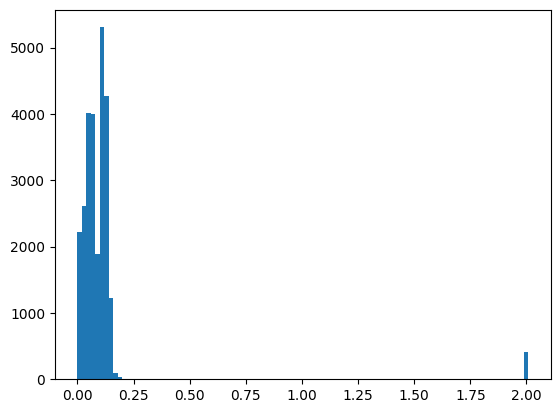

In [87]:
# Plot the magnitude of the changes across the actions
actions_diffs_mag = np.linalg.norm(actions_diffs, axis=-1)

plt.hist(actions_diffs_mag, bins=100);

In [92]:
# How many are very close to zero?
isclose = np.isclose(actions_diffs, 0, atol=0.0001).all(axis=-1)

In [96]:
robot_state_changes[isclose].max(0)

array([0.00022422, 0.        , 0.00571061], dtype=float32)